In [76]:
from modAL import batch, uncertainty, density, utils
from modAL.models import ActiveLearner
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from functools import partial
from typing import Union, Tuple
import pandas as pd

In [48]:
confidence_query_log = []

In [91]:
def active_split(X, Y, shuffle=True):
    """
    Split data into three sets:
    * Labeled training set (0.1)
    * Unlabeled training set, to be queried (0.4)
    * Labeled test set (0.5)
    """

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, shuffle=shuffle)
    X_labelled, X_unlabelled, Y_labelled, Y_oracle = train_test_split(X_train, Y_train, test_size=0.9, shuffle=shuffle)

    return X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test

def active_learn(X, y, query_strategy) -> Tuple[list, list]:
    """
    Perform active learning on the given dataset using a linear SVM model, querying data with the given query strategy.

    Returns the accuracy curve.
    """
    X_labelled, X_unlabelled, Y_labelled, Y_oracle, X_test, Y_test = active_split(X, y, shuffle=False)
    learner = ActiveLearner(
        estimator=svm.SVC(kernel='rbf', probability=True), 
        X_training=X_labelled, 
        y_training=Y_labelled, 
        query_strategy=query_strategy
    )

    trained = [len(X_labelled)]
    accuracy = [learner.score(X_test, Y_test)]
    while len(X_unlabelled) != 0:
        query_idx, _ = learner.query(X_unlabelled)
        learner.teach(X_unlabelled[query_idx], Y_oracle[query_idx])
        X_unlabelled = np.delete(X_unlabelled, query_idx, axis=0)
        Y_oracle = np.delete(Y_oracle, query_idx, axis=0)
        trained.append(trained[-1]+10)
        accuracy.append(learner.score(X_test, Y_test))
    return (trained, accuracy)

def random_batch(
    classifier: sklearn.base.BaseEstimator, 
    X: Union[list, np.ndarray], 
    n_instances: int = 1, 
    random_tie_break: bool = False, 
    **uncertainty_measure_kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    idx = np.random.choice(X.shape[0], n_instances)
    return (idx, X[idx])

def query_logger(
    query_func, classifier, X, n_instances=1, **kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    global confidence_query_log
    chosen = query_func(classifier, X, n_instances=n_instances, **kwargs)
    confidence_query_log.append(X[chosen])
    return chosen

def uncertainty_id(clf, X, n_instances=1, **kwargs):
    """
    Sort by the minimum highest confidence labelling.
    """
    return np.argsort(uncertainty.classifier_uncertainty(clf, X) * density.information_density(X))[:n_instances]


In [5]:
def loadData_abalone(dataset_size=4177):
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
    dataset = pd.read_csv(url, header=None)
    y = dataset[0].to_numpy()
    isInB = np.array([dataset.to_numpy()[i,6]<0.144 for i in range(len(dataset))])
    isInB = isInB.reshape(len(isInB), 1)
    X = dataset.drop([0,6], axis=1).to_numpy()
    #pca = PCA(n_components=21).fit(X)
    #X = pca.transform(X)
    X = np.append(X, isInB, axis=1)
    
    return X, y

In [15]:
X, y = loadData_abalone()

In [83]:
information_density = density.information_density(X)

In [65]:
uncertainty_results = active_learn(X, y, partial(batch.uncertainty_batch_sampling, n_instances=10))

In [ ]:
random_results = active_learn(X, y, partial(random_batch, n_instances=10))

In [68]:
margin_results = active_learn(X, y, partial(uncertainty.margin_sampling, n_instances=10))

In [69]:
entropy_results = active_learn(X, y, partial(uncertainty.entropy_sampling, n_instances=10))

In [92]:
uncertainty_id_results = active_learn(X, y, partial(uncertainty_id, n_instances=10))

In [81]:
help(uncertainty_id())

Help on function query_strategy in module modAL.utils.combination:

query_strategy(classifier: sklearn.base.BaseEstimator, X: Union[scipy.sparse.csr.csr_matrix, pandas.core.frame.DataFrame, numpy.ndarray, list]) -> Tuple



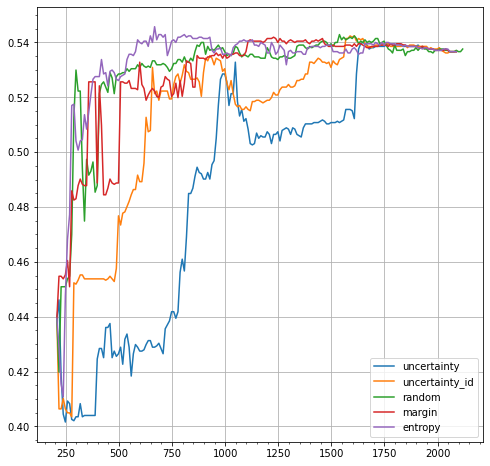

In [93]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(uncertainty_results[0], uncertainty_results[1], label="uncertainty")
ax.plot(uncertainty_id_results[0], uncertainty_id_results[1], label="uncertainty_id")
ax.plot(random_results[0], random_results[1], label="random")
ax.plot(margin_results[0], margin_results[1], label="margin")
ax.plot(entropy_results[0], entropy_results[1], label="entropy")
ax.grid()
ax.minorticks_on()
ax.legend();

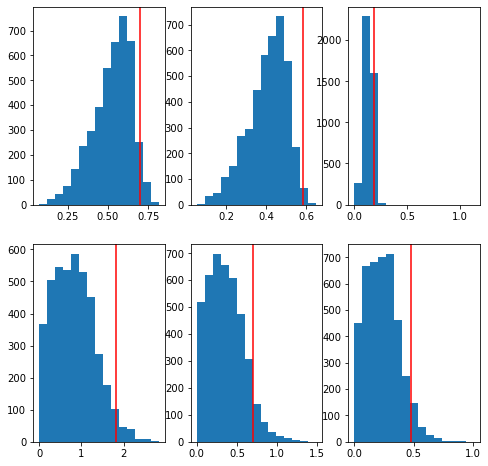

In [64]:
fig, axes = plt.subplots(2,3, figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    ax.hist(X[:,i], bins=15)
    ax.axvline(confidence_query_log[0][0][i], color='red')

In [55]:
confidence_query_log[0][0]

array([ 0.7   ,  0.585 ,  0.185 ,  1.8075,  0.7055,  0.475 , 29.    ,
        0.    ])